# Telco Customer Churn Analysis
## Aim of the project
We have a classification problem. We wil make classification on the target variable Churn and we will build a model to get best classification possible on the target variable. We will look at the balance of the target variable. As we will see later, our target variable has imblanced data For that reason we are not going to use only Accuracy score, Based on the problem on the hand, we will use Combination of Recall and Accuracy scores. In order to combat class imbalance we can consider under/oversampling or drawing test data with equal proportions of classes.

## Data Dictionary

- CustomerID: A unique ID that identifies each customer.
- Gender: The customer’s gender: Male, Female
- Age: The customer’s current age, in years, at the time the fiscal quarter ended.
- Senior Citizen: Indicates if the customer is 65 or older: Yes, No
- Married (Partner): Indicates if the customer is married: Yes, No
- Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
- Number of Dependents: Indicates the number of dependents that live with the customer.
- Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
- Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No
- Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
- Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No
- Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No
- Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No
- Premium Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No
- Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
- Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
- Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check
- Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
- Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
- Tenure: Indicates the total amount of months that the customer has been with the company.
- Churn: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Data Source - https://www.kaggle.com/datasets/blastchar/telco-customer-churn

# Exploratory Data Analysis
Importing necessary libraries

In [366]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import os
import warnings
import statsmodels.api as sm
import xgboost as xgb


from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
import xgboost as xgb

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


Data import and first glimpse

In [367]:
df=pd.read_csv(r'C:\Users\xtaym\Desktop\VSC projects\datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [368]:
#sum of na's for every variable
print(df.isna().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [369]:
# checking number of duplicates
print(df.duplicated().sum())

0


In [370]:
# datatypes
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Our data is complete. No records are duplicated nor missing. We will modify few columns:
- customerID - dropped because it has no influence on churn
- TotalCharges - changing datatype from object to float
- Churn - We will encode churn to 0/1 values

In [371]:
# droping ID column
df=df.drop(columns='customerID',axis=1)

# we encountered a problem when converting Charges to float type, there were empty values. We converted them to Nan's and then converted column to float
df['TotalCharges']=df['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
print(df['TotalCharges'].isna().sum(), 'number of NAs')

#
#df['SeniorCitizen']=df['SeniorCitizen'].astype(object)
#df['Churn']=df['Churn'].astype(object)


# we will drop them because their number is irrelevant
df=df.dropna()
print(df['TotalCharges'].isna().sum(), 'number of NAs post deletion')

11 number of NAs
0 number of NAs post deletion


There is a imbalance across classes it will be taken into account when sampling data for model developement.

## Target Variable
Our target variable is churn. It states whether or not customer resigned from our companys services. 

Churn
No     5163
Yes    1869
Name: count, dtype: int64 
 Percentage of clients that churned: 0.27 
 Percentage of clients that stayed with the company: 0.73


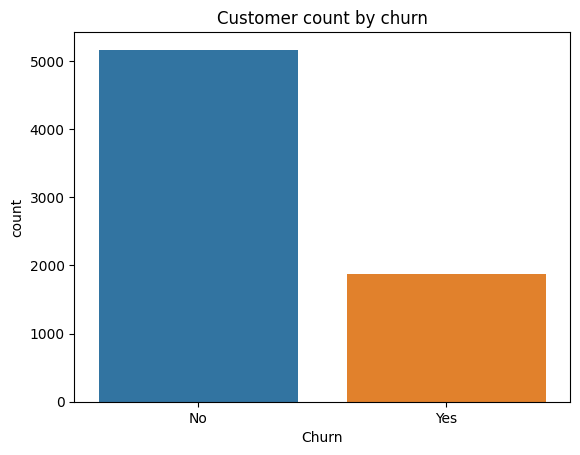

In [372]:
#countplot of churn variable 
sns.countplot(df,x='Churn').set(title='Customer count by churn')
print(df['Churn'].value_counts(),'\n',
      'Percentage of clients that churned:' , round(df['Churn'][df['Churn']=='Yes'].value_counts()[0]/len(df),2),'\n',
      'Percentage of clients that stayed with the company:', round((1-(df['Churn'][df['Churn']=='Yes'].value_counts()[0])/len(df)),2))

We have imbalanced data. About 27% of the customers churned. Almost 73% of the customers stayed with the company.
1869 customer churned while 5174 customer did not.

In [373]:
#encoding 0/1 values to Churn var
le = LabelEncoder()
df['Churn']=le.fit_transform(df['Churn'])

#printing numerical and categorical columns
num_cols= df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns

print(
f'Numerical Columns:  {df[num_cols].columns}','\n','\n',
f'Categorical Columns: {df[cat_cols].columns}')
# for the sake of simplicity at this point we will treat Senior Citizen and Churn as numerical variables.

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object') 
 
 Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [374]:
#Descriptive statistics of variables
df[num_cols].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


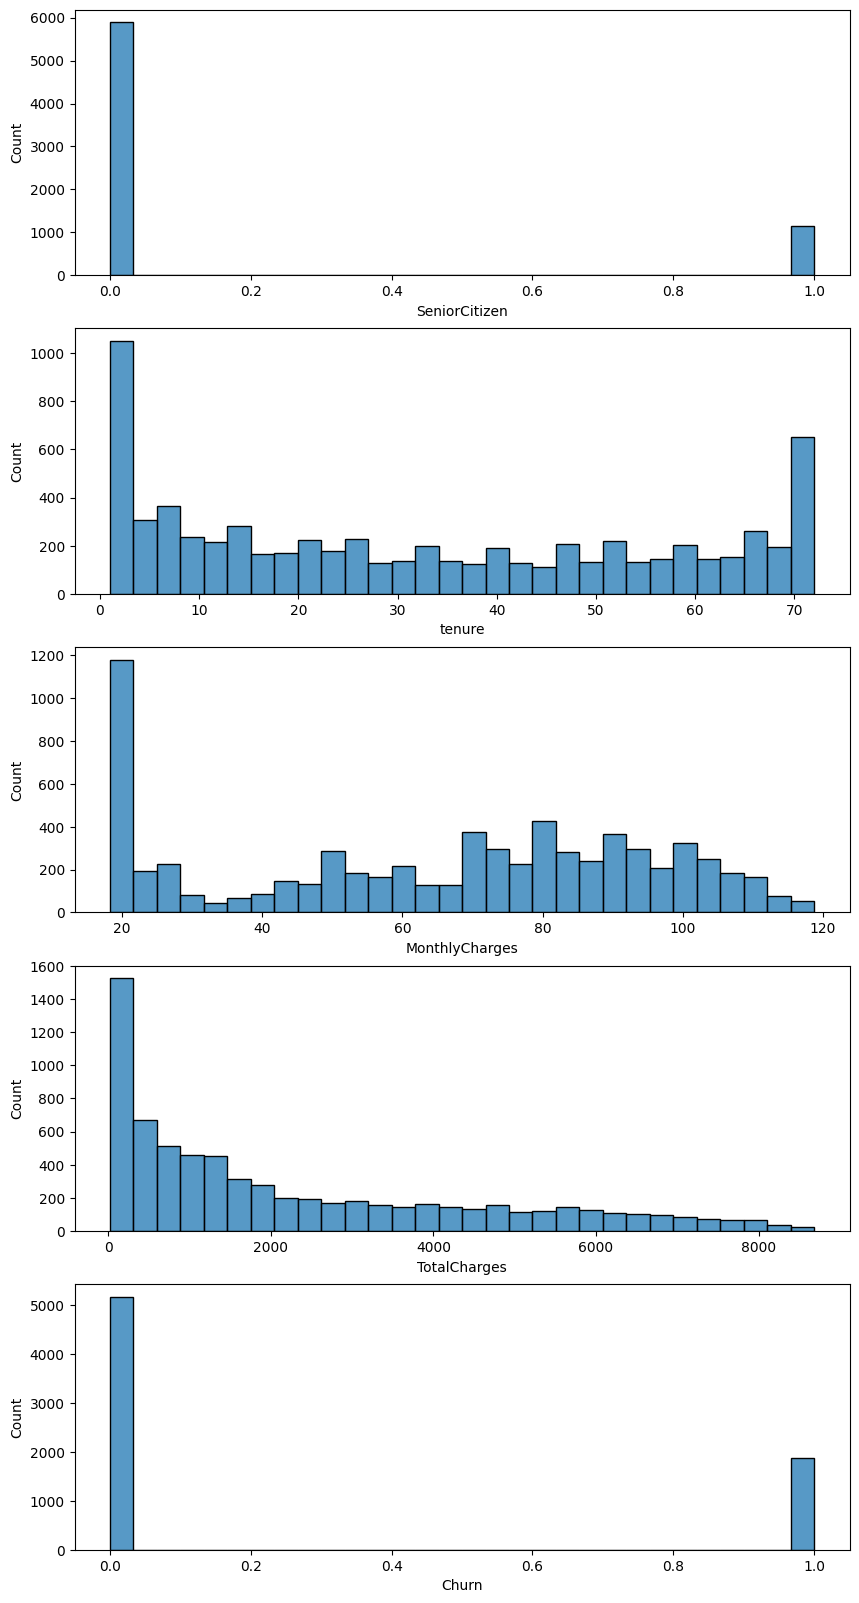

In [375]:
#histograms of numerical variables
fig, ax =plt.subplots(len(num_cols),1,figsize=(10, 4 * len(num_cols)))
#plt.rcParams["figure.figsize"] = [30, 5]

for i, col in enumerate(df[num_cols].columns):
    sns.histplot(data=df, x=col,ax=ax[i],bins=30)

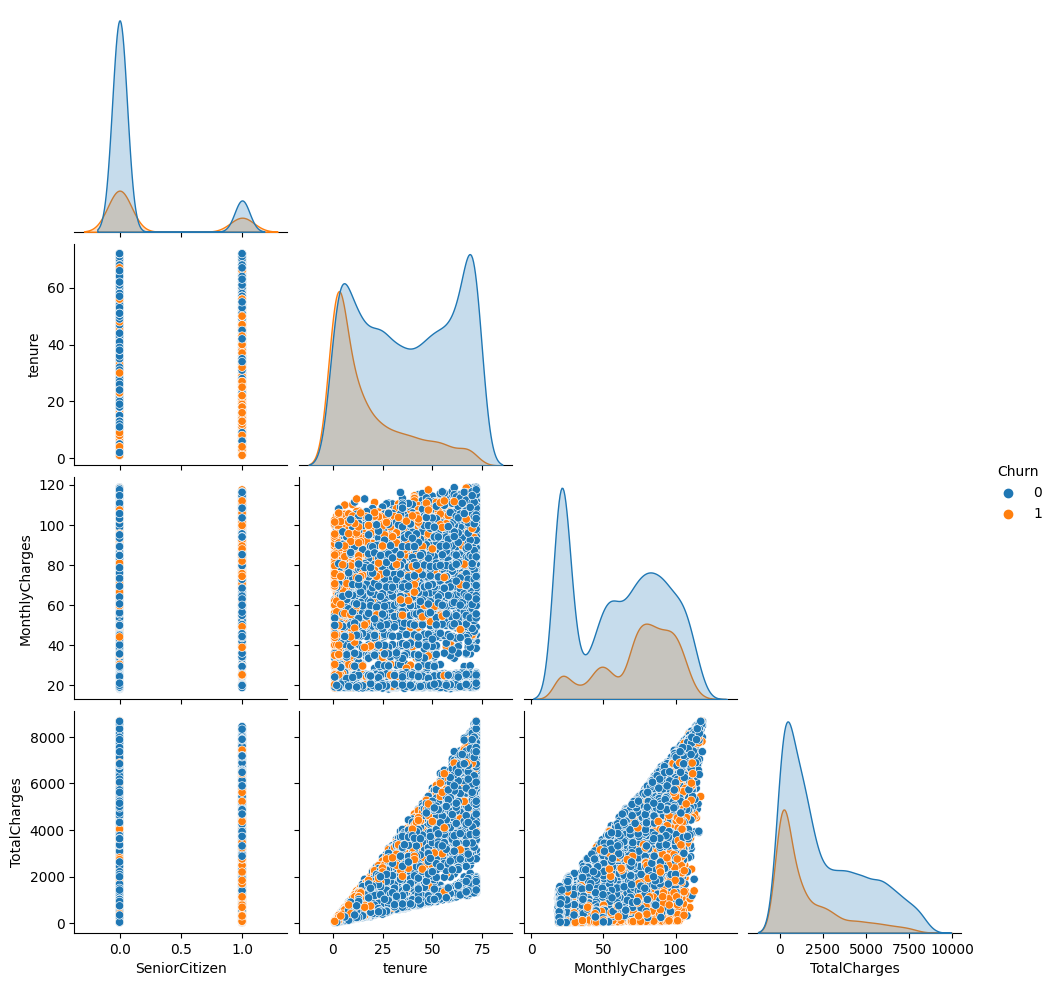

In [376]:
#relationships between churn and numerical variables
sns.pairplot(data=df,hue='Churn',corner=True)

Clients with shorter tenure have a higher chance of churn. The higher MonthlyCharges client has the more likely he is to Churn. Senior Citizens tend to Churn more often. We will examine it further using correlation.

<Axes: >

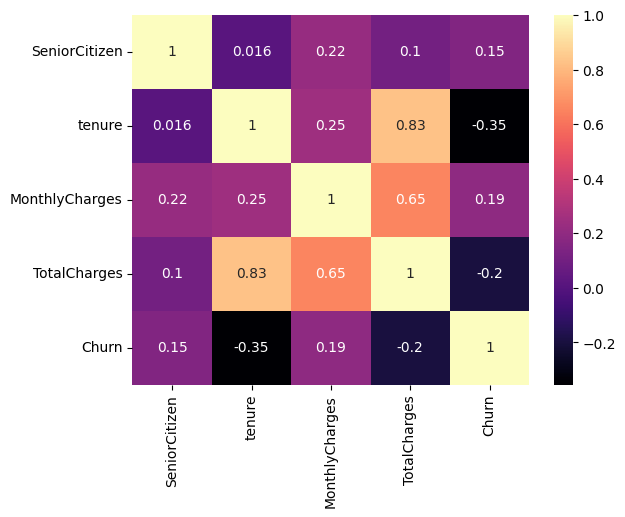

In [377]:
# plotting heatmap of correlation
sns.heatmap(df[num_cols].corr(),annot=True,cmap="magma")

The analysis of the dataset reveals several noteworthy correlations between the numerical features and the target variable:

- We observe a modest level of correlation between the numerical features and the target variable.
- Senior citizen status and higher monthly charges exhibit a positive correlation with customer churn.
- Senior citizens are more prone to churn compared to younger customers.
- Customers with elevated monthly charges are also more inclined to churn in contrast to those with lower monthly charges.
- Long-term customers are less likely to churn compared to those with a shorter history with the company.
- A robust positive correlation exists between tenure and total charges.
- Notably, total charges demonstrate a negative correlation with churn.

## Bivariate analysis
Now we will take a look at relationship of the categorical columns on Churn.

In [378]:
# Adding merged column to analyze Churn depending on contract type and column
df['merged']=df['Churn'].astype(str)+' : '+df['Contract']

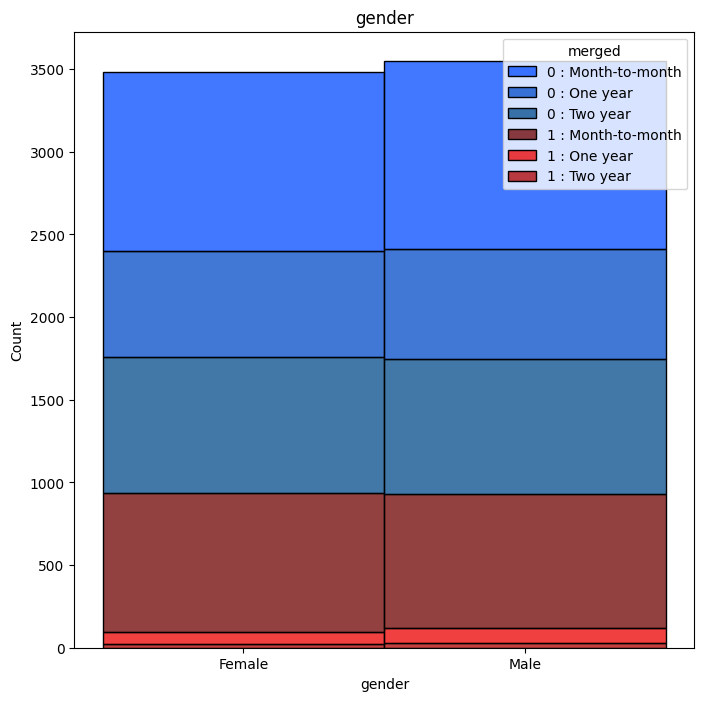

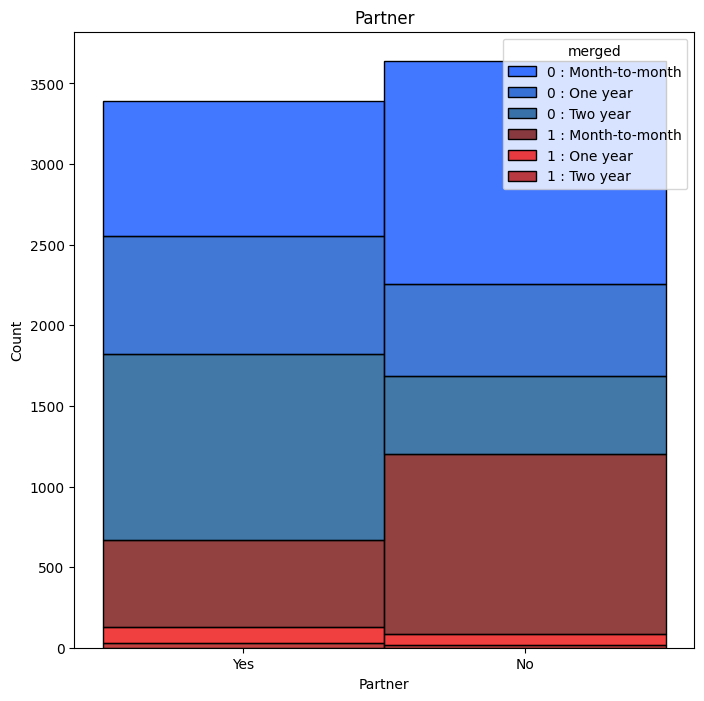

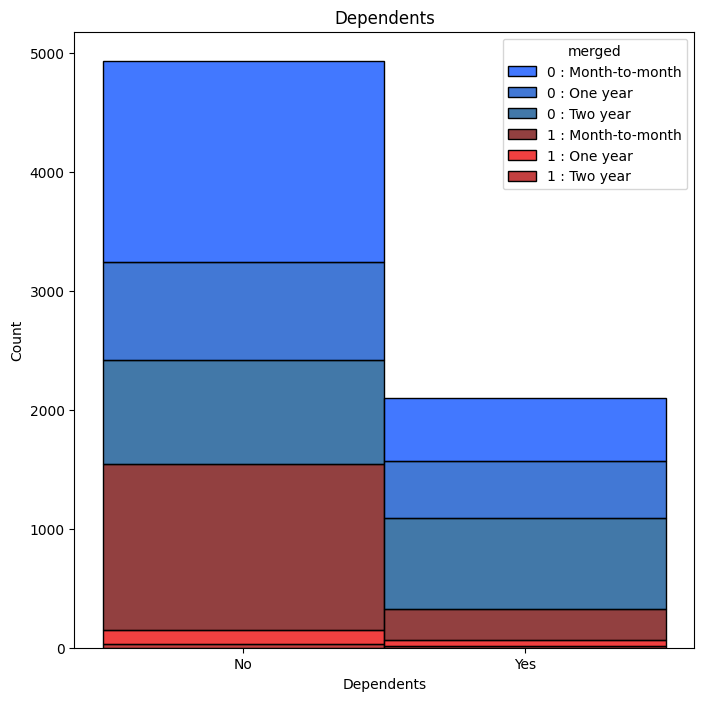

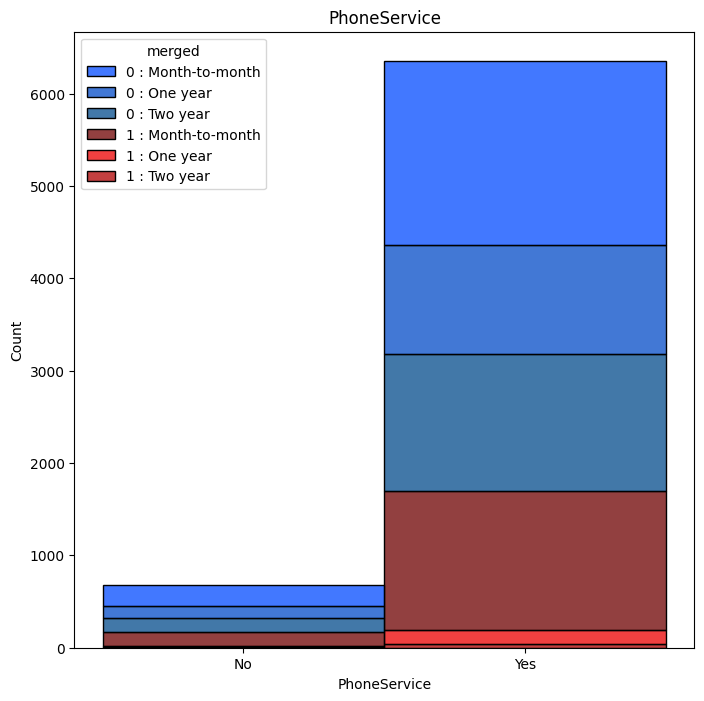

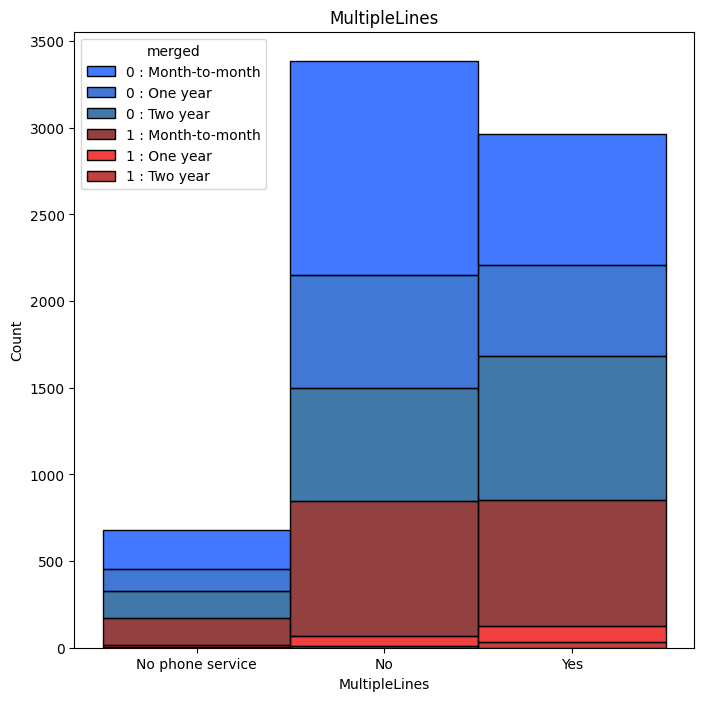

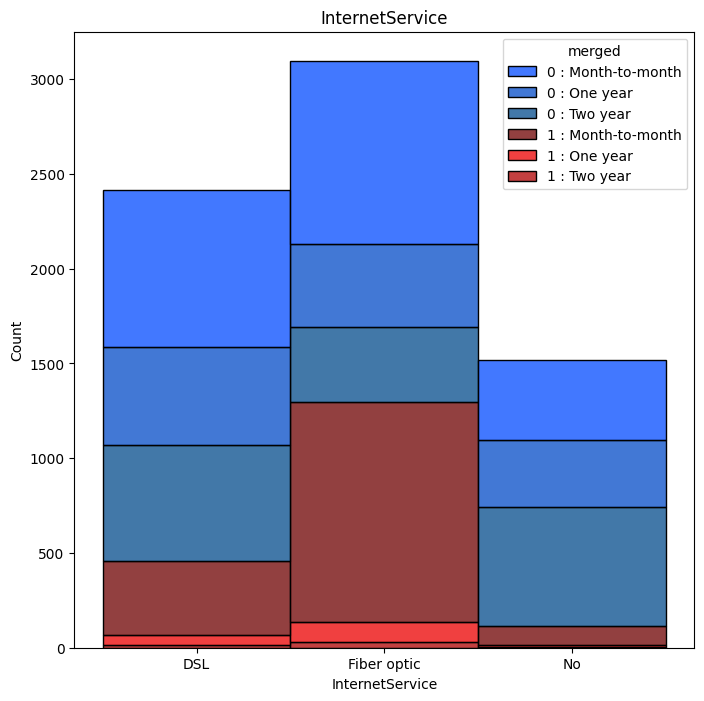

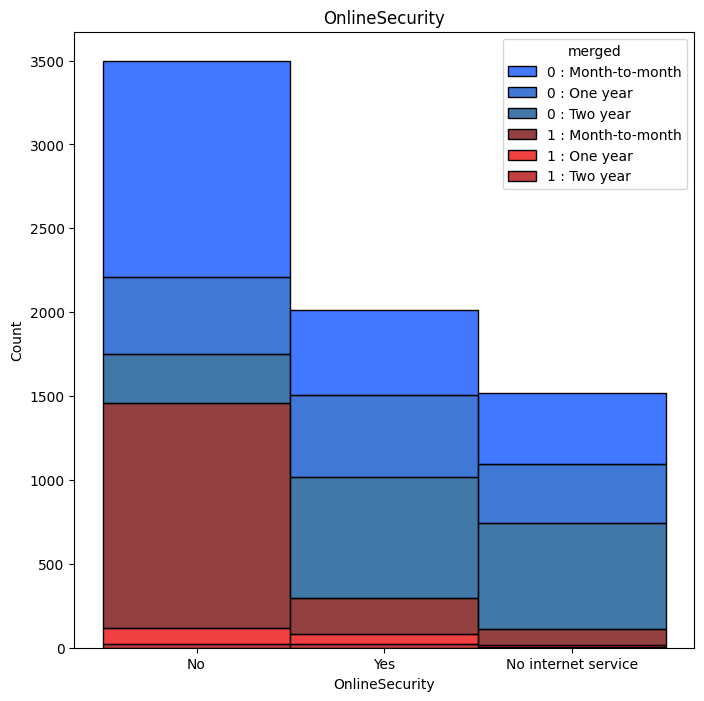

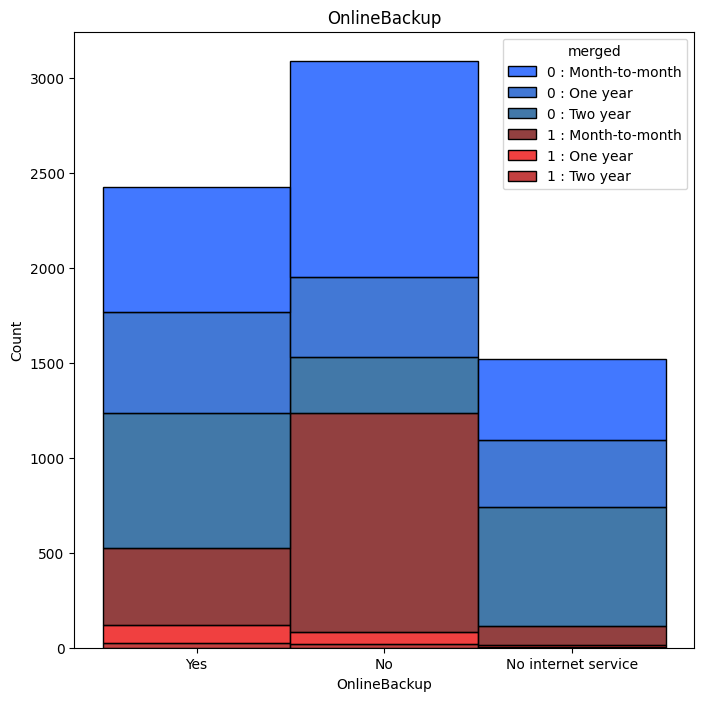

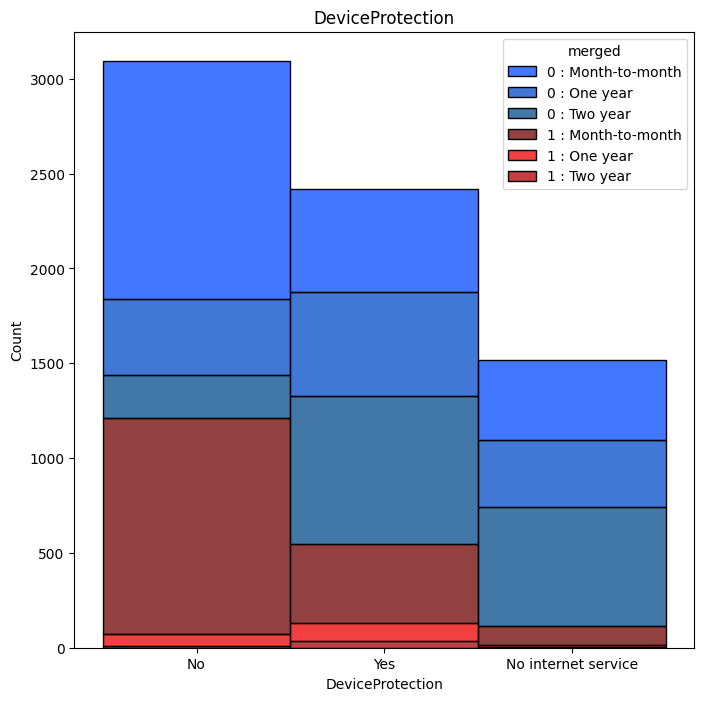

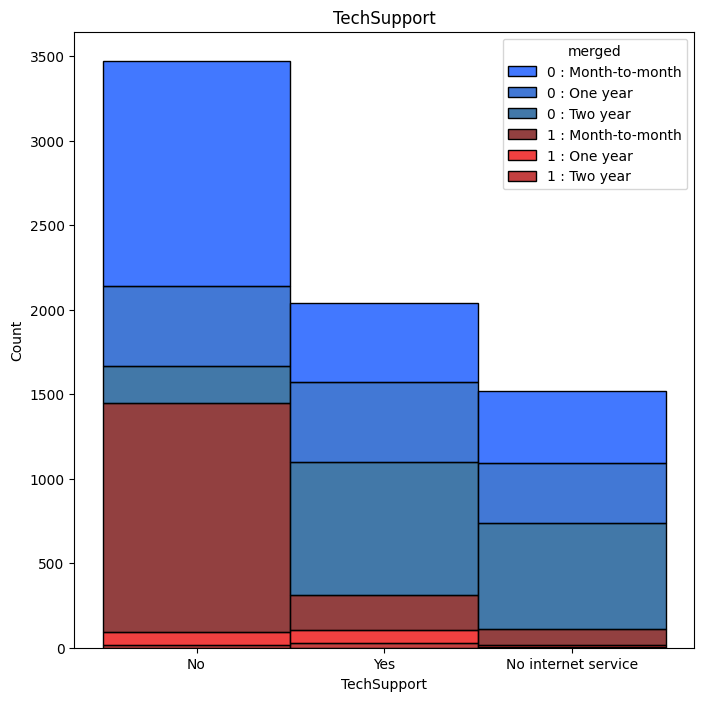

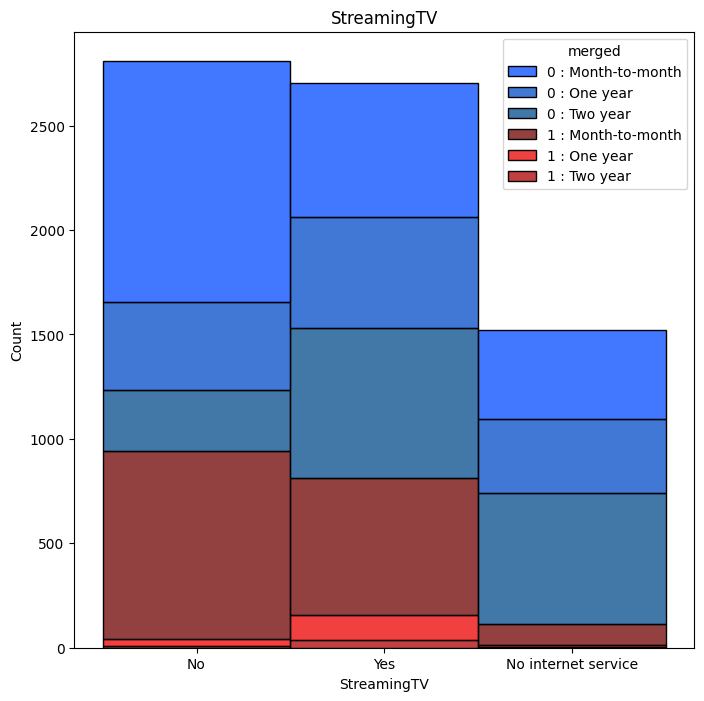

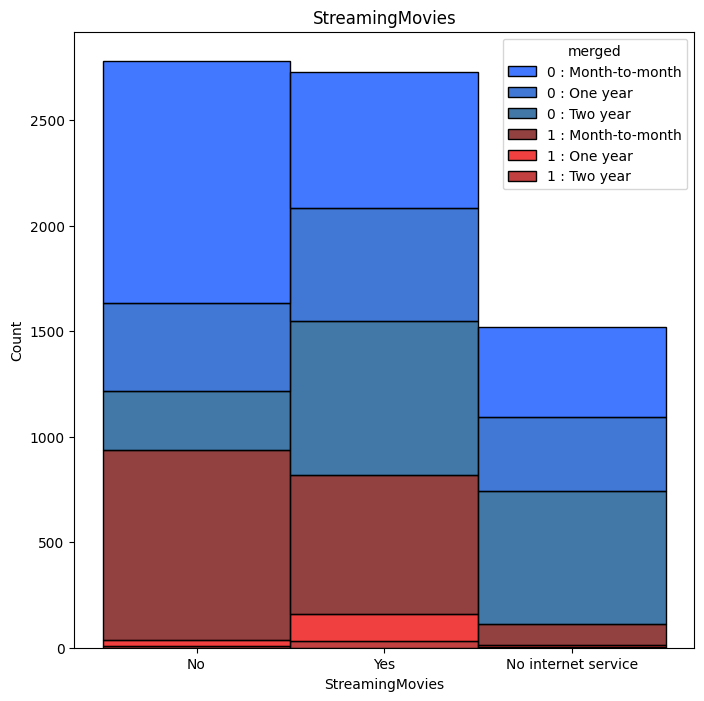

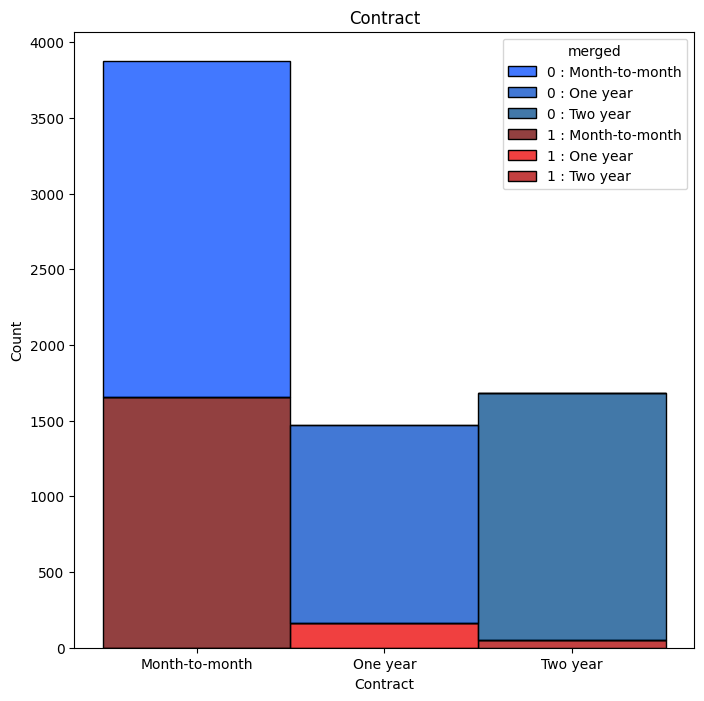

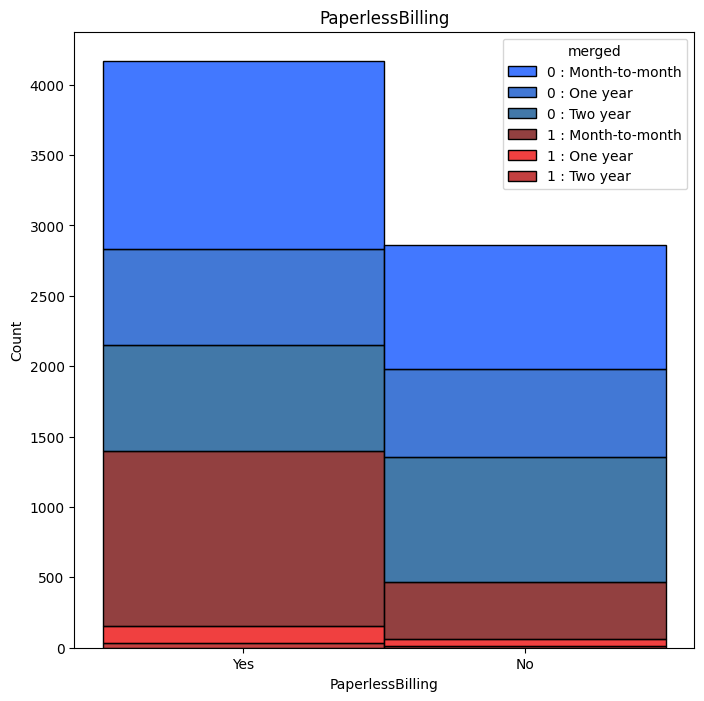

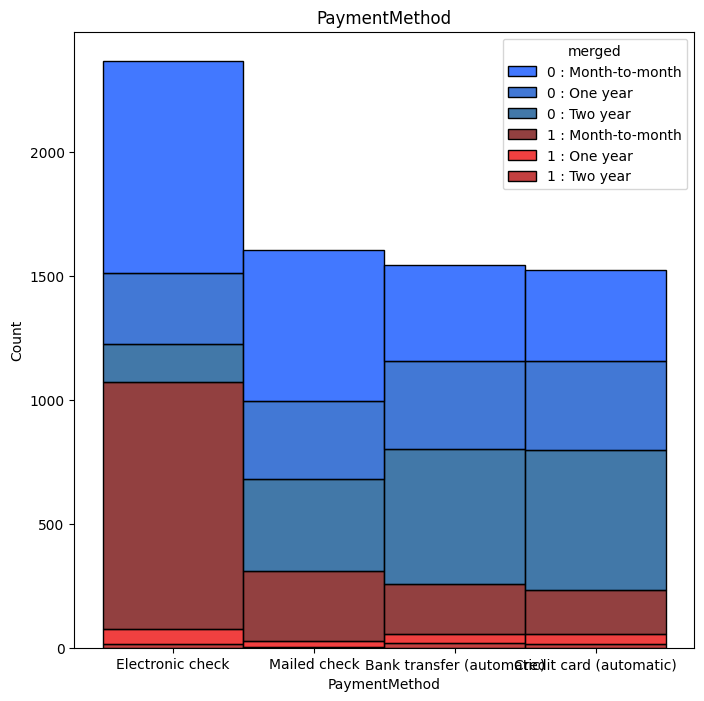

In [379]:
#colorcoding
colors = {'0 : Month-to-month':'#024bff', '0 : One year':'#024bc7',
       '0 : Two year':'#024b8b', '1 : Month-to-month':'#6e0000', '1 : Two year':'#af0000', '1 : One year':'#eb0000'}

#loop that will plot histograms of Churn for different groups of customers 
for i, col in enumerate(df[cat_cols].columns):
    plt.figure(figsize=(8, 8))
    sns.histplot(data=df, hue="merged", x=col, multiple="stack",palette=colors,hue_order=['0 : Month-to-month', '0 : One year',
       '0 : Two year','1 : Month-to-month', '1 : One year','1 : Two year'])
    plt.title(col)
    plt.show()

Different Groups have different share of Churners, this shows us potential for creation of machine learning that will help us judge which clients decide to churn. 

## Modeling
We will create linear regression model, random forest and xgb models. We will use regression as benchmark for other models. In order to compare them we hsould look at more metrics than only accuracy, recall and precision are also important. From these 2 we ideally want to see higher recall.

In [380]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,merged
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0 : Month-to-month
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0 : One year
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 : Month-to-month
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0 : One year
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 : Month-to-month


In [381]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1973)

Data has been split to test and train subsets. Test set is 30% of the original dataset.

## Approach
We want to predict if client churned or not. We will use and compare multiple methods in order to achieve this goal. Based on this we will find a method that works best in our scenario.

### Linear Regression
First we will create linear Regression model using all available variables.

In [383]:
X_train_oh=pd.get_dummies(X_train.drop(columns=['merged']), dtype=float, drop_first=True)
X_test_oh=pd.get_dummies(X_test.drop(columns=['merged']), dtype=float, drop_first=True)

Creating dummy variables, also known as one-hot encoding, is necessary in linear regression when you have categorical variables because linear regression is designed to work with numerical data.

In [384]:
#fit regression model
model_lr = LogisticRegression(random_state=1973)
model_lr.fit(X_train_oh,np.array(y_train).reshape(-1, 1),)
y_lr_predict=model_lr.predict(X_test_oh)


In [385]:
# function that we will use to compare models later on
def evaluate(model, test_features, test_labels,ret_acc=True,ret_all=False):
    predictions = model.predict(test_features)
    accuracy=accuracy_score(test_labels,predictions)
    recall=recall_score(test_labels,predictions)
    precision=precision_score(test_labels,predictions)
    print(f"""Model Performance: 
    Accuracy = {round(accuracy*100,3)}%
    Recall = {round(recall*100,3)}%
    Precision = {round(precision*100,3)}%""")
    if ret_all==True:
        return accuracy,recall,precision
    elif ret_acc==True: 
        return accuracy
    

In [386]:
evaluate(model_lr,X_test_oh,y_test,ret_acc=False)

Model Performance: 
    Accuracy = 80.19%
    Recall = 53.02%
    Precision = 69.604%


Without any tweaking of linear regression we are able to achieve performance shown above. Acurraccy is sufficient, however recall achieved could be better. Currently only 69.6% of clients that will churn are labeled correctly. We will use this model as a benchmark while using other methods.

## Findings from first model
Our business goal is to identify as many customers that will churn as possible. We want to max out all 3 metrics, ideally we would have 100% recall in precision meaning that we will correctly label 100% of churners with 100% of accuracy.

- Accuracy is 80.19%: This means that the model correctly predicted approximately 80.19% of all cases, considering both customers who churned and those who did not. In other words, out of all predictions made by the model, about 80.19% were correct.
- Recall is 69.6%: The recall score of 69.6% indicates that the model successfully identified roughly 69.6% of the customers who actually churned. This metric measures the model's ability to capture churned customers out of all the customers who churned. In this case, the model identified about half of the churning customers.
- Precision is 53.02%: Precision at 53.02% tells us that when the model predicted a customer to churn, it was accurate approximately 53.02% of the time. In other words, out of all the predictions of churn made by the model, roughly 53.02% were correct.

## Improving our base model
We will consider addressing class imbalance first!
Also when evaluating models we base on combination of Acurraccy and Recall. Ideally both should be above 75%.
### Introduction
Class imbalance is a common challenge in machine learning, particularly in binary classification tasks. In this report, we explore strategies to combat class imbalance in a dataset with 7,000 records, ensuring that our machine learning model can effectively learn from both minority and majority classes. Addressing class imbalance is crucial to prevent the model from being biased toward the majority class and to improve its predictive performance.
### Method and strategies
1. Modify the Decision Threshold and Use Different Evaluation Metrics - 
Adjust the classification threshold to increase sensitivity (lower threshold) or specificity (higher threshold) based on specific project objectives and requirements. Rely on metrics such as precision, recall, F1-score, ROC AUC, or PR AUC instead of accuracy to assess model performance, as they offer a more comprehensive view of performance in imbalanced datasets.
2. Ensemble Methods Consider using ensemble methods like Random Forest, Gradient Boosting, or Balanced Random Forest, which handle imbalanced datasets more effectively by giving weight to different classes. We will try that later, now we want to tweak only our base linear regression first.
3. Resampling Techniques, Through simple resampling we should be able to achieve better results.
- Oversampling: Increase the number of Churn instances by duplicating or generating synthetic samples using methods like SMOTE or ADASYN.
- Undersampling: Reduce the number of No Churn instances by randomly removing samples. Be cautious to avoid loss of critical information.
- Combination of Oversampling and Undersampling: A balanced approach that combines both oversampling and undersampling techniques to address class imbalance.

I decided to use undersampling because we have sufficient amounts of data in this case.

In [387]:
under_samp=RandomUnderSampler(random_state=1973)
X_train_oh_resamp, y_train_resamp = under_samp.fit_resample(X_train_oh, y_train)


In [388]:
print(f"""value counts pre resampling - \n{y_train.value_counts()},\n\nvalue conuts after resampling - \n{y_train.value_counts()}""")

value counts pre resampling - 
Churn
0    3649
1    1273
Name: count, dtype: int64,

value conuts after resampling - 
Churn
0    3649
1    1273
Name: count, dtype: int64


### Linear Regression Resampled
As we can see resampling reduced class imbalance.

In [389]:
#fit regression model
model_lr_resamp = LogisticRegression(random_state=1973)
model_lr_resamp.fit(X_train_oh_resamp,y_train_resamp)

#view summary of model fit
y_pred_resamp = model_lr_resamp.predict(X_test_oh)

In [390]:
evaluate(model_lr_resamp,X_test_oh,y_test,ret_acc=False)

Model Performance: 
    Accuracy = 75.545%
    Recall = 82.047%
    Precision = 54.454%


After resampling our model is overall less accurate (smaller Accuracy). It labels bigger share of churners correctly (increased recall), however predictions made are less precise (lower precision). In our case we want to label as much churners correctly as possible, we would prefer to have higher recall than precision. We will continue to use undersampled data, we will train our models on  transformed data. This could be wrong in the long term because class balance can change, in real life models and class distributions are monitored and adjusted if needed. 

In [391]:
#fit regression model
model_rf = RandomForestClassifier(random_state=1973)
model_rf.fit(X_train_oh_resamp,y_train_resamp)

#view summary of model fit
y_for_predict=model_rf.predict(X_test_oh)

In [392]:
evaluate(model_rf,X_test_oh,y_test,ret_acc=False)

Model Performance: 
    Accuracy = 74.976%
    Recall = 77.181%
    Precision = 53.991%


### Tweaking Random Forest with Grid Search
Base Random Forest is not better than initial Logistic Regression Model. We will try to tweak our Random Forest model through random grid search and grid search

Brief theory: 
- Grid Search is a systematic hyperparameter optimization technique where you specify a predefined set of hyperparameters and their potential values.
- It creates a grid of all possible combinations of hyperparameters and performs a separate model training and evaluation for each combination.
- Grid Search is an exhaustive and time-consuming approach, as it tests all combinations, making it suitable for smaller hyperparameter spaces. Random Grid Search is a more efficient variation of Grid Search. It randomly samples hyperparameter values within specified ranges, reducing the exhaustive search.
- In both techniques, the process typically involves evaluating the model's performance using a cross-validation setup to ensure robustness and prevent overfitting. The best-performing hyperparameter combination is then chosen to build the final model.

Using Random Grid Search to find more optimal parameters in more efficient way than in normal grid search.

In [393]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 101, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_random_grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [394]:
# Use the random grid to search for best hyperparameters
rf=RandomForestClassifier(random_state=1973)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_random_grid_params, n_iter = 100, cv = 3, verbose=2, random_state=1973, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_oh_resamp, y_train_resamp)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1973),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 14, 24, 33, 43, 53, 62,
                                                      72, 81, 91, 101, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1973, verbose=2)

In [395]:
best_params_rf_random=rf_random.best_params_
rf_random_grid=RandomForestClassifier(**best_params_rf_random)
rf_random_grid.fit(X_train_oh_resamp,y_train_resamp)

RandomForestClassifier(max_depth=62, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=1000)

In [396]:
base_accuracy = evaluate(model_rf, X_test_oh, y_test)
random_accuracy = evaluate(rf_random_grid, X_test_oh, y_test)

print('Improvement of {:0.3f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance: 
    Accuracy = 74.976%
    Recall = 77.181%
    Precision = 53.991%


Model Performance: 
    Accuracy = 75.45%
    Recall = 80.705%
    Precision = 54.412%
Improvement of 0.632%.


Using grid search to further tweak the parameters found in random grid search in previous step.

In [397]:
best_params_rf_random

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 62,
 'bootstrap': True}

In [398]:
# Create the parameter grid based on the results of random search 
param_grid_rf = {
    'bootstrap': [True],
    'max_depth': [best_params_rf_random['max_depth']-2,best_params_rf_random['max_depth'],best_params_rf_random['max_depth']+2],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [2,3,4],
    'n_estimators': [best_params_rf_random['n_estimators']-200,best_params_rf_random['n_estimators'],best_params_rf_random['n_estimators']+200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [399]:
# Fit the grid search to the data
grid_search.fit(X_train_oh_resamp, y_train_resamp)
grid_search.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [400]:
rf_grid_params=grid_search.best_params_
rf_grid_search=RandomForestClassifier(**rf_grid_params)
rf_grid_search.fit(X_train_oh_resamp,y_train_resamp)

RandomForestClassifier(max_depth=60, min_samples_leaf=4, n_estimators=1200)

In [401]:
base_accuracy = evaluate(rf_random_grid, X_test_oh, y_test)
random_accuracy = evaluate(rf_grid_search, X_test_oh, y_test)

print('Improvement of {:0.3f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance: 
    Accuracy = 75.45%
    Recall = 80.705%
    Precision = 54.412%
Model Performance: 
    Accuracy = 75.735%
    Recall = 80.537%
    Precision = 54.795%
Improvement of 0.377%.


By using Grid search we were able to further improve Accuracy and Recall of our model meaning that we will be more accurate in our predictions. Not only that we will be able to sucessfully predict more churners.
### XGBOOST
Knowing that random forest has potential we will also test XGBOOST algorithm.
XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm known for its exceptional performance in various tasks, such as classification and regression. It is an ensemble learning method that combines the predictions of multiple decision trees to create a robust and accurate model. XGBoost is widely used due to its efficiency, speed, and ability to handle complex datasets.

First we will create base XGB classifier to see its performance, then we will tweak its parameters by using grid search.

In [402]:
# Define the base XGBoost model
xgb_model = xgb.XGBClassifier()

xgb_basic=xgb_model.fit(X_train_oh_resamp,y_train_resamp)
evaluate(xgb_basic,X_test_oh,y_test)

Model Performance: 
    Accuracy = 72.37%
    Recall = 75.839%
    Precision = 50.73%


0.723696682464455

In [422]:
# Hyperparameter grid for Randomized Grid Search
random_param_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Randomized Grid Search
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=random_param_xgb, n_iter=20, scoring='accuracy', n_jobs=-1, cv=3, verbose=1,random_state=1973)
random_search_xgb.fit(X_train_oh_resamp, y_train_resamp)

# Get the best hyperparameters from Randomized Grid Search
best_params_xgb_random = random_search_xgb.best_params_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [423]:
# Create a new XGBoost model with the best hyperparameters
better_xgb_model = xgb.XGBClassifier(**best_params_xgb_random)

# Fit the model to the training data
better_xgb_model.fit(X_train_oh_resamp, y_train_resamp)

# Calculate accuracy on the test set
evaluate(better_xgb_model,X_test_oh,y_test)

Model Performance: 
    Accuracy = 75.261%
    Recall = 79.866%
    Precision = 54.214%


0.75260663507109

In [405]:
best_params_xgb_random

{'subsample': 1.0,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.9}

In [406]:
# Hyperparameter grid for Grid Search
xgb_param_grid = {
    'n_estimators': [40,50,60,70,80,100],
    'max_depth': [2,3, 4, 5],
    'learning_rate': [0.05,0.1, 0.2,0.25],
    'subsample': [0.8,0.9,1,1.1],
    'colsample_bytree': [0.6,0.7,0.8, 0.9, 1.0]
}

# Grid Search
grid_search_xgb = GridSearchCV(xgb_model, param_grid=xgb_param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=1)
grid_search_xgb.fit(X_train_oh, y_train)

# Get the best hyperparameters from Grid Search
best_params_xgb_grid = grid_search_xgb.best_params_

Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


In [407]:
best_params_xgb_grid

{'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 50,
 'subsample': 0.9}

In [424]:
# Create a new XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params_xgb_grid)

# Fit the model to the training data
best_xgb_model.fit(X_train_oh_resamp, y_train_resamp)

# Calculate accuracy on the test set
base_accuracy = evaluate(xgb_basic, X_test_oh, y_test)
random_accuracy = evaluate(best_xgb_model, X_test_oh, y_test)

print('Improvement of {:0.3f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance: 
    Accuracy = 72.37%
    Recall = 75.839%
    Precision = 50.73%
Model Performance: 
    Accuracy = 75.308%
    Recall = 82.215%
    Precision = 54.144%
Improvement of 4.060%.


By using grid search we were able to improve our models accuracy by 3.3%. Recall improved by around 10%. Thanks to it our model became more acurate and will achieve better results in identifying churners.

### Comparing models
We will compare models that we created and optimized prior to this point in order to choose the best one for this use case.

In [425]:
# creating list of models that we used prior
models_to_score=[model_lr,model_lr_resamp,model_rf,rf_random_grid,rf_grid_search,xgb_basic,better_xgb_model,best_xgb_model]

In [426]:
#
results_data = []

for model in models_to_score:
    # model name to str
    model_name = str(model)

    # evaluating every model by itterating over it
    accuracy,recall,precision=evaluate(model,X_test_oh,y_test,ret_all=True)
    
    # Append the results to the DataFrame
    model_results = pd.DataFrame({"Model": [model_name], "Accuracy": [accuracy], "Recall": [recall], "Precision": [precision]})
    results_data.append(model_results)

    results_df = pd.concat(results_data, ignore_index=True)
# df with models results

Model Performance: 
    Accuracy = 80.19%
    Recall = 53.02%
    Precision = 69.604%
Model Performance: 
    Accuracy = 75.545%
    Recall = 82.047%
    Precision = 54.454%
Model Performance: 
    Accuracy = 74.976%
    Recall = 77.181%
    Precision = 53.991%


Model Performance: 
    Accuracy = 75.45%
    Recall = 80.705%
    Precision = 54.412%
Model Performance: 
    Accuracy = 75.735%
    Recall = 80.537%
    Precision = 54.795%
Model Performance: 
    Accuracy = 72.37%
    Recall = 75.839%
    Precision = 50.73%
Model Performance: 
    Accuracy = 75.261%
    Recall = 79.866%
    Precision = 54.214%
Model Performance: 
    Accuracy = 75.308%
    Recall = 82.215%
    Precision = 54.144%


In [427]:
 # Convert to string if not already
results_df['Model'] = results_df['Model'].astype(str)

# Apply the regular expression to each element in the 'Model' column in order to clean the names
results_df['Model'] = results_df['Model'].apply(lambda x: re.findall(r'^(.*?)\(', x)[0] if re.findall(r'^(.*?)\(', x) else x)
# The above line applies the regex pattern to each element, extracts the part before the first '(', and updates the 'Model' column.


In [428]:

#renaming models
model_renaming = {
    0: "LogisticRegression",
    1: "Logistic Regression Resamp",
    2: "Random Forest",
    3: "Random Forest Random Grid Search",
    4: "Random Forest Grid Search",
    5: "XGB Classifier",
    6: "XGB Classifier Random Grid",
    7: "XGB Classifier Grid Search"
}

results_df['Model'] = results_df.index.map(model_renaming)

# Reshape the DataFrame
results_df = results_df.melt(id_vars=['Model'], value_vars=['Accuracy', 'Recall', 'Precision'], var_name='Attribute', value_name='Value')


In [429]:
#sorting values
results_df = results_df.sort_values(by=['Attribute','Value'],ascending=[True,True])

In [465]:
results_df.head()

,Model,Attribute,Value
5,XGB Classifier,Accuracy,0.723697
2,Random Forest,Accuracy,0.749763
6,XGB Classifier Random Grid,Accuracy,0.752607
7,XGB Classifier Grid Search,Accuracy,0.753081
3,Random Forest Random Grid Search,Accuracy,0.754502


<Figure size 1000x600 with 0 Axes>

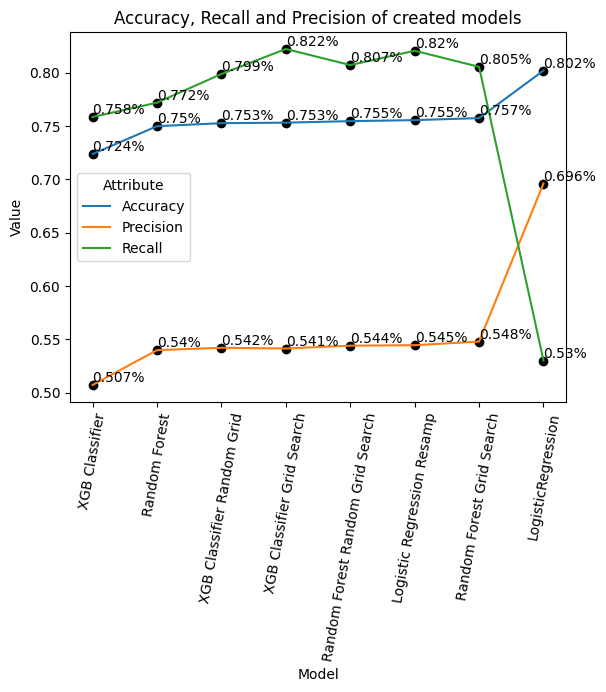

<Figure size 1000x600 with 0 Axes>

In [431]:
#ploting different models metrics

sns.lineplot(results_df,y='Value',hue='Attribute',x='Model',estimator=None).set(title='Accuracy, Recall and Precision of created models')

for i, j in zip(results_df['Model'], results_df['Value']):
    plt.text(i, j, f'{round(j,3)}%', va='bottom')
    plt.scatter(i, j, marker='o',color='black')
plt.xticks(rotation=80)

plt.figure(figsize=(10, 6))


#### Evaluation
Almost all models produce similiar accuracy, with XGBoost optimized usind Grid Search being the best in this metric.
- Goal - identify churners

With goal in mind I think we should look not only at accuracy metric but also at recall and precision. Knowing that i would implement either XGBoost optimized using grid search or Random Forest optimized using grid Search. Both are similiar in terms of metrics. My choice in this case would be XGBoost because its faster and more efficient, not only that it has better precision and accuracy with recall being smaller only by 0.01% percentage point. Much better Precision will decrease the number of wrongly identifying Churners which could make our loyal customers angry if we target some retention campaign towards them.

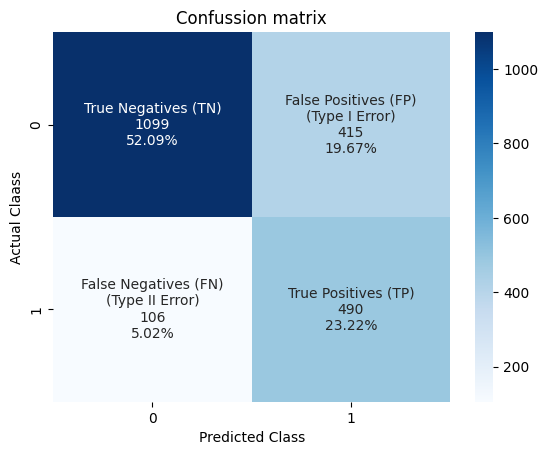

In [464]:
y_pred=best_xgb_model.predict(X_test_oh)

confusion = confusion_matrix(y_test, y_pred)
group_names = ["True Negatives (TN)", "False Positives (FP)\n(Type I Error)", "False Negatives (FN)\n(Type II Error)", "True Positives (TP)"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion, annot=labels, fmt="", cmap="Blues")
ax.set(xlabel="Predicted Class", ylabel = "Actual Claass",title='Confussion matrix');

- For 5.02% clients we fail to correctly label them as Churners meaning that we are not able to conduct any anti Churn effort. 
- 19.67% clients will stay with us but our model predicts that they will churn
- in 75.3% of cases we correctly identify clients churn

## Further steps
It is propably possible to tweak our model even more by feature enginerring or better tweaking our model. We can definietly look at reclassifying some variables to YES/NO from YES/NO/NO INTERNET, this has potential to influence the outcome of our model. Apart from that we can artificially lower the probability at which model assumes someone churn's, doing that will make our model label more customers as Churners meaning that we will lose some accuracy at cost of increasing Recall. In order to achieve that we should measure model scores at different threshold levels and choose one that fits our business need best.

## Threshold adjustment
We can adjust threshold manually in order to achieve higher recall at cost of precision.

In [433]:
def test_thresh(x):
    threshold_value=[]
    scores_acc=[]
    scores_f1=[]
    scores_rec=[]
    scores_prec=[]
    for i in np.linspace(0, 1, 101):
        threshold = i  # You can adjust the threshold as needed
        y_pred_fun = (x[:, 1] > threshold).astype(int)
        threshold_value.append(i)
        scores_acc.append(accuracy_score(y_test, y_pred_fun))
        scores_f1.append(f1_score(y_test, y_pred_fun))
        scores_rec.append(recall_score(y_test, y_pred_fun))
        scores_prec.append(precision_score(y_test, y_pred_fun))
        #scores_roc.append(roc_auc_score(y_test, y_prob))
    return pd.DataFrame({'threshold_value':threshold_value,'score_acc':scores_acc,'score_f1':scores_f1,'score_rec':scores_rec,'score_prec':scores_prec})

In [438]:
y_prob_xgb = best_xgb_model.predict_proba(X_test_oh)  

In [435]:
temp=model_lr_resamp.predict_proba(X_test_oh)

<Axes: >

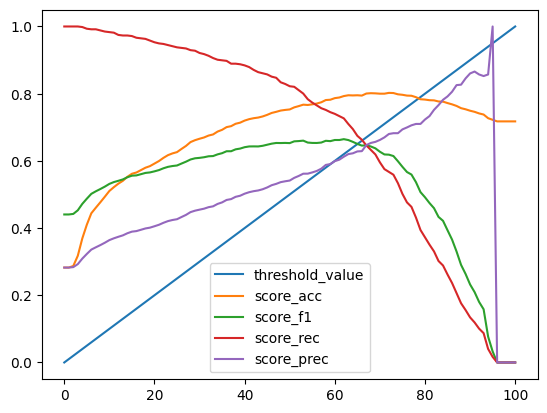

In [439]:
test_thresh(y_prob_xgb).plot()

In [491]:
def acc_rec_prec(x,thresh=0.5):
    y_pred_final = (x[:,1].reshape(len(x),1) > thresh) # Predict class 1 if probability > threshold

    # Evaluate the model
    accuracy_final = accuracy_score(y_test, y_pred_final)
    recall_final=recall_score(y_test, y_pred_final)
    precision_final=precision_score(y_test, y_pred_final)
    print(f"""After manual threshold manipulation:
    Accuracy = {round(accuracy_final*100,2)}%
    Recall = {round(recall_final*100,3)}%
    Precision = {round(precision_final*100,2)}%""")


In [492]:
evaluate(best_xgb_model,X_test_oh,y_test)

acc_rec_prec(y_prob_xgb,thresh=0.63)

Model Performance: 
    Accuracy = 75.308%
    Recall = 82.215%
    Precision = 54.144%
After manual threshold manipulation:
    Accuracy = 78.67%
    Recall = 73.993%
    Precision = 59.92%


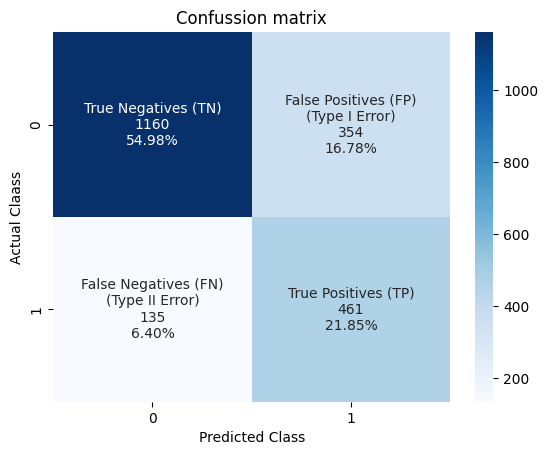

In [494]:
y_pred_final = (y_prob_xgb[:,1].reshape(len(y_prob_xgb),1) > 0.63)

group_names = ["True Negatives (TN)", "False Positives (FP)\n(Type I Error)", "False Negatives (FN)\n(Type II Error)", "True Positives (TP)"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion, annot=labels, fmt="", cmap="Blues")
ax.set(xlabel="Predicted Class", ylabel = "Actual Claass",title='Confussion matrix');

Threshold in a chance above which we will assume someone churns. By increasing threshold to 63% we increased Accuracy and Precision at cost of Recall. Number of Type II Errors increased meaning that we fail to correctly predict higher share of churners. Type I Error count decreased meaning that we no longer falsly accuse our customers of churning.
## Findings
There is no one fits all model to this problem. A lot depends on our business needs. In this data we know nothing about the true cost of making Type I and II errors, based on them we should adjust our approach in real life. In this case I choose XGB model optimized with gridsearch, because it was able to achieve good Recall and Accuracy. Additionally we were able to further tweak the model by manually increasing the threshold, the final threshold should be decided by our business case, there is no universal solution. 

In future in order to further tweak our model we can try using different resampling techniques and cross-validation. CV will enable us to decrease overfitting and reduce test errors.